# Test if the model of PCA+SVM is robust in our data set

In [2]:
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


Using TensorFlow backend.


In [3]:
df = create_dataframe('/../raw_data/dataset_062920.json',image_size=(25,50))
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.43529411764705883, 0.41568627450980394, 0...","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.15294117647058825, 0.12156862745098039, 0...","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.1607843137254902, 0.13333333333333333, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.17254901960784313, 0.12941176470588237, 0...","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.4980392156862745, 0.4627450980392157, 0.5...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [4]:
def create_binary_labels(y_labels):
    """
    takes in our original y labels, each label is in the form of [x,y]
    convert the original labels into a new y labels which is "R" when x>0, "L" elsewise
    input:
        y_labels: a 1*n pandas df with its element in the form of [x,y]
    output:
        a converted binary label with its element == R if x>0 eles L
    """
    binary_labels = pd.DataFrame().reindex_like(y_labels)
    isRight = y_labels["y"].map(lambda x: x[0]) >0
    binary_labels.loc[isRight] = "R"
    binary_labels.loc[~isRight] = "L"
    return binary_labels


In [5]:
def test_robustness(df):
    """
    For testing the robustness of our PCA+SVM model when we split the train and test randomly
    """
    train_scores, test_scores = [], []
    for i in range(200):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())
        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])
        pca = PCA(n_components=150, whiten=True, random_state=42)
        svc = SVC(kernel='linear', C=0.05)
        svm_model = make_pipeline(pca, svc)
        svm_model.fit(eyeImage_train, y_train_binary)
        # param_grid = {'svc__C': [100,50,10,5,1,0.5,0.1, 0.05, 0.01, 0.005, 0.001]}
        # grid = GridSearchCV(svm_model, param_grid)
        # %time grid.fit(eyeImage_train, y_train_binary)
        # print(grid.best_params_)

        # svm_model = grid.best_estimator_

        train_score = svm_model.score(eyeImage_train, y_train_binary, sample_weight=None)
        test_score = svm_model.score(eyeImage_test, y_test_binary, sample_weight=None)

        train_scores.append(train_score)
        test_scores.append(test_score)
        svm_model = None

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [6]:
result_df = test_robustness(df)

In [7]:
result_df

,train_score,test_score
0,0.976351,0.889764
1,0.981419,0.838583
2,0.976351,0.885827
3,0.976351,0.862205
4,0.962838,0.893701
...,...,...
195,0.971284,0.874016
196,0.972973,0.897638
197,0.972973,0.834646
198,0.979730,0.862205


In [8]:
result_df.to_csv("results/pca_svm_cv.csv")

In [9]:
result_df.mean(axis=0)

train_score    0.976512
test_score     0.873780
dtype: float64

In [10]:
result_df.std(axis=0)

train_score    0.005413
test_score     0.020089
dtype: float64

In [11]:
y_train.index

NameError: name 'y_train' is not defined

In [12]:
print(classification_report(y_test_binary, yfit))
 

NameError: name 'y_test_binary' is not defined

In [13]:
yfit_train = svm_model.predict(eyeImage_train)
print(classification_report(y_train_binary, yfit_train))

NameError: name 'svm_model' is not defined

Text(0.5, 1.0, 'Accuracy of PCA+SVM in 200 random train-test splits')

<Figure size 432x288 with 0 Axes>

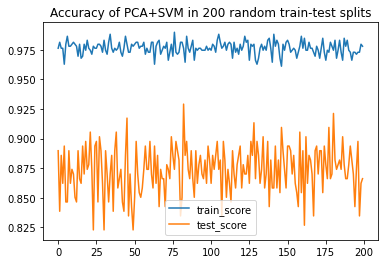

In [14]:
plt.figure()
result_df.plot()
plt.legend(loc="best")
plt.title("Accuracy of PCA+SVM in 200 random train-test splits")
# plt.savefig("results/pca_svm_cv_acc_0707.png")

## 2. Only use far left and far right data

In [18]:
# create a extreme df
is_far_right = df["y"].map(lambda x: x[0]>0.7)
is_far_left = df["y"].map(lambda x: x[0]<-0.7)
df_extreme = df.loc[is_far_right | is_far_left]

In [19]:
result_df = test_robustness(df_extreme)
result_df.mean(axis=0)


train_score    0.999492
test_score     0.920197
dtype: float64

In [21]:
result_df.std()

train_score    0.001213
test_score     0.022098
dtype: float64

<Figure size 432x288 with 0 Axes>

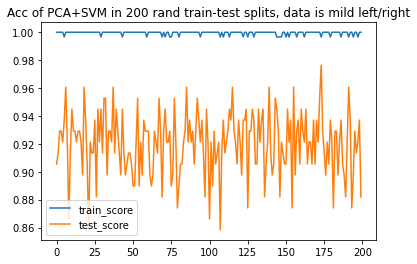

In [20]:
plt.figure()
result_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+SVM in 200 rand train-test splits, data is mild left/right")
# plt.savefig("results/pca_svm_cv_acc_mild_0707.png")